## Import packages

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import torch
import torch.nn.functional as F

from tqdm import tqdm
from torchinfo import summary
from models.unet import UNet
from models.dataset import InpaintingDataset
from models.network import make_beta_schedule
%matplotlib inline

In [2]:
b, c, h, w = 3, 3, 256, 256

denoise_fn = UNet(
    in_channel=2 * c,
    out_channel=c,
    inner_channel=64,
    channel_mults=(1, 2, 4, 8),
    attn_res=[16],
    num_head_channels=32,
    res_blocks=2,
    dropout=0.2,
    image_size=256,
)

x = torch.randn((b, 2 * c, h, w))
emb = torch.ones((b, 1))
summary(denoise_fn, input_data=(x, emb), device=torch.device("cpu"))

/home/guyi/miniconda3/envs/llama/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/guyi/miniconda3/envs/llama/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [3, 3, 256, 256]          --
├─Sequential: 1-1                             [3, 256]                  --
│    └─Linear: 2-1                            [3, 256]                  16,640
│    └─SiLU: 2-2                              [3, 256]                  --
│    └─Linear: 2-3                            [3, 256]                  65,792
├─ModuleList: 1-2                             --                        --
│    └─EmbedSequential: 2-4                   [3, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                       [3, 64, 256, 256]         3,520
│    └─EmbedSequential: 2-5                   [3, 64, 256, 256]         --
│    │    └─ResBlock: 3-2                     [3, 64, 256, 256]         107,008
│    └─EmbedSequential: 2-6                   [3, 64, 256, 256]         --
│    │    └─ResBlock: 3-3                     [3, 64, 256, 256]         107,008

## Import Dataset

In [3]:
dataset = InpaintingDataset(data_path="./data/celeba_hq_256_full.flist", mask_mode="hybrid", data_len=-1, image_size=[256, 256])
len(dataset)

30000

In [4]:
dataset[0]

{'gt_image': tensor([[[-0.3098, -0.3098, -0.3098,  ..., -0.7569, -0.7569, -0.7569],
          [-0.3098, -0.3098, -0.3098,  ..., -0.7647, -0.7569, -0.7569],
          [-0.3098, -0.3098, -0.3098,  ..., -0.7647, -0.7647, -0.7647],
          ...,
          [-0.2784, -0.2784, -0.2784,  ...,  0.0196, -0.0431, -0.0980],
          [-0.2784, -0.2784, -0.2784,  ...,  0.0510, -0.0039, -0.0588],
          [-0.2863, -0.2863, -0.2863,  ...,  0.0745,  0.0196, -0.0353]],
 
         [[-0.3961, -0.3961, -0.3961,  ..., -0.5843, -0.5843, -0.5843],
          [-0.3961, -0.3961, -0.3961,  ..., -0.5922, -0.5843, -0.5843],
          [-0.3961, -0.3961, -0.3961,  ..., -0.5922, -0.5922, -0.5922],
          ...,
          [-0.3490, -0.3490, -0.3490,  ...,  0.1137,  0.0588,  0.0196],
          [-0.3490, -0.3490, -0.3490,  ...,  0.1451,  0.0980,  0.0588],
          [-0.3569, -0.3569, -0.3569,  ...,  0.1686,  0.1216,  0.0824]],
 
         [[-0.5686, -0.5686, -0.5686,  ..., -0.4039, -0.4039, -0.4039],
          [-0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


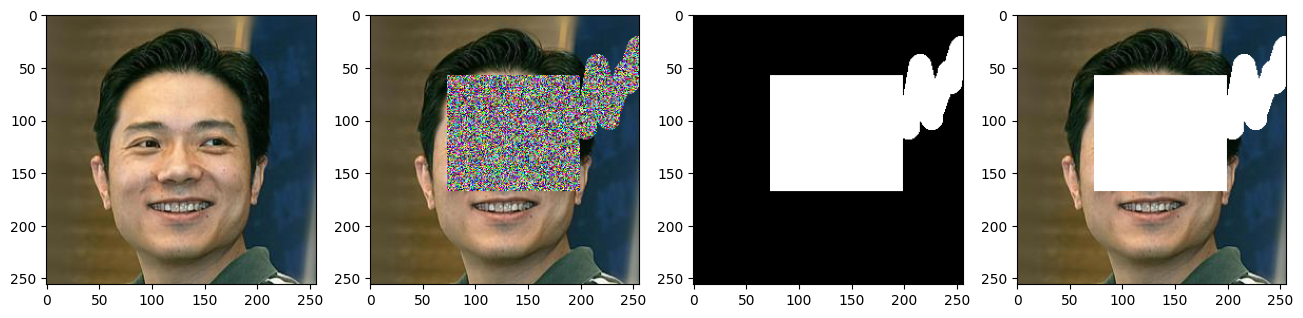

In [5]:
single_data = dataset[0]
plt.subplots(1, 4, figsize=(16, 4), dpi=100)
plt.subplot(1, 4, 1)
plt.imshow((single_data["gt_image"].permute(1, 2, 0) + 1) / 2)
plt.subplot(1, 4, 2)
plt.imshow((single_data["cond_image"].permute(1, 2, 0) + 1) / 2)
plt.subplot(1, 4, 3)
plt.imshow(single_data["mask"].permute(1, 2, 0), cmap="gray")
plt.subplot(1, 4, 4)
plt.imshow((single_data["mask_image"].permute(1, 2, 0) + 1) / 2)

In [6]:
betas = make_beta_schedule("linear", 2000, 1e-6, 0.01)
betas

array([1.0000000e-06, 6.0020010e-06, 1.1004002e-05, ..., 9.9899960e-03,
       9.9949980e-03, 1.0000000e-02])

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012]),
 [Text(0, -0.002, '$\\mathdefault{−0.002}$'),
  Text(0, 0.0, '$\\mathdefault{0.000}$'),
  Text(0, 0.002, '$\\mathdefault{0.002}$'),
  Text(0, 0.004, '$\\mathdefault{0.004}$'),
  Text(0, 0.006, '$\\mathdefault{0.006}$'),
  Text(0, 0.008, '$\\mathdefault{0.008}$'),
  Text(0, 0.01, '$\\mathdefault{0.010}$'),
  Text(0, 0.012, '$\\mathdefault{0.012}$')])

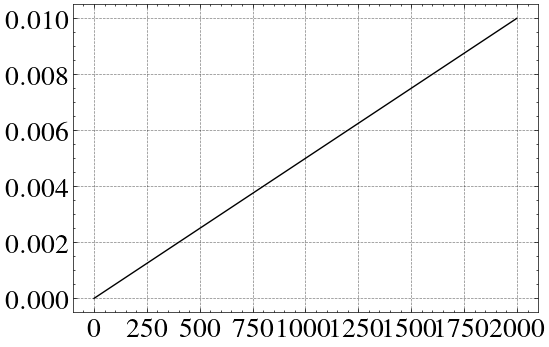

In [30]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(betas))), betas)

## Calculate all constants

$\gamma = \prod_0^t \alpha_i$

In [8]:
betas = torch.tensor(betas, dtype=torch.float32)
alphas = 1.0 - betas
(timesteps, ) = betas.shape
gammas = np.cumprod(alphas, axis=0)
gammas = torch.tensor(gammas, dtype=torch.float32)

/tmp/ipykernel_3441484/3436455520.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gammas = torch.tensor(gammas, dtype=torch.float32)


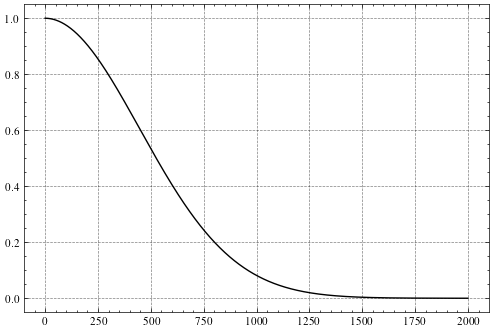

In [9]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(gammas))), gammas)

In [10]:
gammas_prev = np.append(1.0, gammas[:-1])
gammas_prev = torch.tensor(gammas_prev, dtype=torch.float32)

calculations for diffusion $q(x_t | x_{t-1})$ and others

In [11]:
sqrt_recip_gammas = np.sqrt(1.0 / gammas)
sqrt_recipm1_gammas = np.sqrt(1.0 / gammas - 1)
sqrt_recip_gammas = torch.tensor(sqrt_recip_gammas, dtype=torch.float32)
sqrt_recipm1_gammas = torch.tensor(sqrt_recipm1_gammas, dtype=torch.float32)

/tmp/ipykernel_3441484/2244138204.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_recip_gammas = torch.tensor(sqrt_recip_gammas, dtype=torch.float32)
/tmp/ipykernel_3441484/2244138204.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_recipm1_gammas = torch.tensor(sqrt_recipm1_gammas, dtype=torch.float32)


calculations for posterior $q(x_{t-1} | x_t, x_0)$

In [12]:
posterior_variance = betas * (1.0 - gammas_prev) / (1.0 - gammas)
posterior_variance = torch.tensor(posterior_variance, dtype=torch.float32)

/tmp/ipykernel_3441484/2843208340.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_variance = torch.tensor(posterior_variance, dtype=torch.float32)


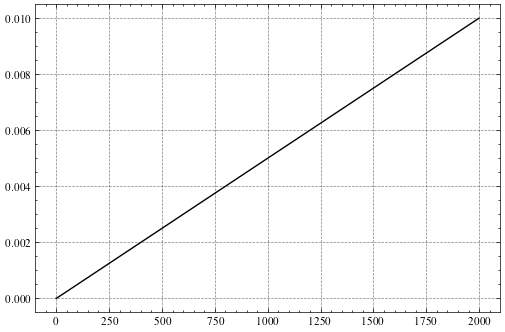

In [13]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(posterior_variance))), posterior_variance)

In [14]:
posterior_log_variance_clipped = np.log(np.maximum(posterior_variance, 1e-20))
posterior_log_variance_clipped = torch.tensor(posterior_log_variance_clipped, dtype=torch.float32)

/tmp/ipykernel_3441484/148861373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_log_variance_clipped = torch.tensor(posterior_log_variance_clipped, dtype=torch.float32)


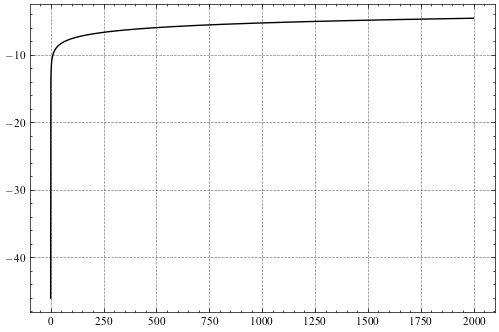

In [15]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(posterior_log_variance_clipped))), posterior_log_variance_clipped)

In [16]:
posterior_mean_coef1 = betas * np.sqrt(gammas_prev) / (1.0 - gammas)
posterior_mean_coef1 = torch.tensor(posterior_mean_coef1, dtype=torch.float32)

/tmp/ipykernel_3441484/3021464480.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_mean_coef1 = torch.tensor(posterior_mean_coef1, dtype=torch.float32)


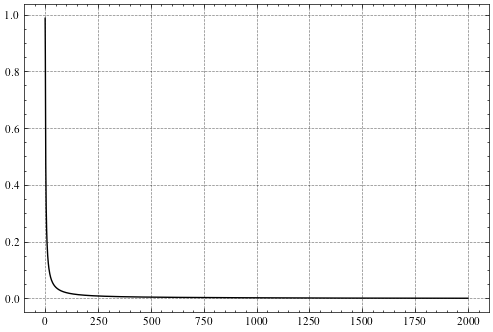

In [17]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(posterior_mean_coef1))), posterior_mean_coef1)

In [18]:
posterior_mean_coef2 = (1.0 - gammas_prev) * np.sqrt(alphas) / (1.0 - gammas)
posterior_mean_coef2 = torch.tensor(posterior_mean_coef2, dtype=torch.float32)

/tmp/ipykernel_3441484/3495330613.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_mean_coef2 = torch.tensor(posterior_mean_coef2, dtype=torch.float32)


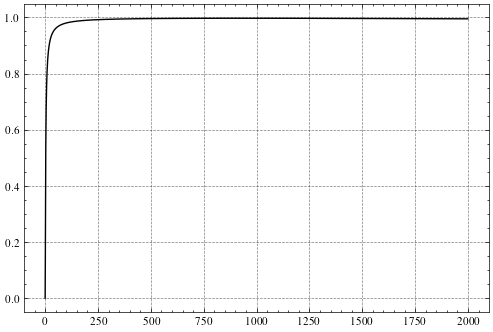

In [19]:
plt.style.use(["science", "ieee", "grid"])
plt.subplots(figsize=(6, 4), dpi=100)
plt.subplot(1, 1, 1)
plt.plot(list(range(len(posterior_mean_coef2))), posterior_mean_coef2)

In [20]:
from inspect import isfunction

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def extract(a, t, x_shape=(1, 1, 1, 1)):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

In [21]:
def predict_start_from_noise(y_t, t, noise):
    return (
        extract(sqrt_recip_gammas, t, y_t.shape) * y_t
        - extract(sqrt_recipm1_gammas, t, y_t.shape) * noise
    )

In [22]:
def q_posterior(y_0_hat, y_t, t):
    posterior_mean = (
        extract(posterior_mean_coef1, t, y_t.shape) * y_0_hat
        + extract(posterior_mean_coef2, t, y_t.shape) * y_t
    )
    p = extract(
        posterior_log_variance_clipped, t, y_t.shape
    )
    return posterior_mean, p

In [23]:
def p_mean_variance(y_t, t, clip_denoised: bool, y_cond=None):
    noise_level = extract(gammas, t, x_shape=(1, 1)).to(y_t.device)
    y_0_hat = predict_start_from_noise(
        y_t,
        t=t,
        noise=denoise_fn(torch.cat([y_cond, y_t], dim=1), noise_level),
    )

    if clip_denoised:
        y_0_hat.clamp_(-1.0, 1.0)

    model_mean, posterior_log_variance = q_posterior(
        y_0_hat=y_0_hat, y_t=y_t, t=t
    )
    return model_mean, posterior_log_variance

In [24]:
def q_sample(y_0, sample_gammas, noise=None):
    noise = default(noise, lambda: torch.randn_like(y_0))
    return sample_gammas.sqrt() * y_0 + (1 - sample_gammas).sqrt() * noise

In [25]:
@torch.no_grad()
def p_sample(y_t, t, clip_denoised=True, y_cond=None):
    model_mean, model_log_variance = p_mean_variance(
        y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond
    )
    noise = torch.randn_like(y_t) if any(t > 0) else torch.zeros_like(y_t)
    return model_mean + noise * (0.5 * model_log_variance).exp()

In [26]:
@torch.no_grad()
def restoration(y_cond, y_t=None, y_0=None, mask=None, sample_num=8):
    b, *_ = y_cond.shape

    assert (
        timesteps > sample_num
    ), "num_timesteps must greater than sample_num"
    sample_inter = timesteps // sample_num

    y_t = default(y_t, lambda: torch.randn_like(y_cond))
    ret_arr = y_t
    for i in tqdm(
        reversed(range(timesteps)),
        desc="sampling loop time step",
        total=timesteps,
    ):
        t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
        y_t = p_sample(y_t, t, y_cond=y_cond)
        if mask is not None:
            y_t = y_0 * (1.0 - mask) + mask * y_t
        if i % sample_inter == 0:
            ret_arr = torch.cat([ret_arr, y_t], dim=0)
    return y_t, ret_arr

In [27]:
def forward(y_0, y_cond=None, mask=None, noise=None):
    b, *_ = y_0.shape
    t = torch.randint(1, timesteps, (b,), device=y_0.device).long()
    gamma_t1 = extract(gammas, t - 1, x_shape=(1, 1))
    sqrt_gamma_t2 = extract(gammas, t, x_shape=(1, 1))
    sample_gammas = (sqrt_gamma_t2 - gamma_t1) * torch.rand(
        (b, 1), device=y_0.device
    ) + gamma_t1
    sample_gammas = sample_gammas.view(b, -1)

    noise = default(noise, lambda: torch.randn_like(y_0))
    y_noisy = q_sample(
        y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1, 1), noise=noise
    )

    if mask is not None:
        noise_hat = denoise_fn(
            torch.cat([y_cond, y_noisy * mask + (1.0 - mask) * y_0], dim=1),
            sample_gammas,
        )
        return mask * noise, mask * noise_hat
    else:
        noise_hat = denoise_fn(
            torch.cat([y_cond, y_noisy], dim=1), sample_gammas
        )
        return noise, noise_hat

/tmp/ipykernel_3441484/2783977364.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_image = torch.tensor(single_data["gt_image"], dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_3441484/2783977364.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond_image = torch.tensor(single_data["cond_image"], dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_3441484/2783977364.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(single_data["mask"], dtype=torch.float32).unsqueeze(0)
Clipping input data to the valid range fo

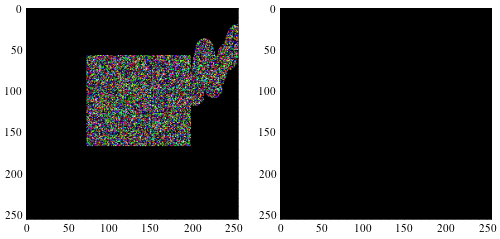

In [28]:
gt_image = torch.tensor(single_data["gt_image"], dtype=torch.float32).unsqueeze(0)
cond_image = torch.tensor(single_data["cond_image"], dtype=torch.float32).unsqueeze(0)
mask = torch.tensor(single_data["mask"], dtype=torch.float32).unsqueeze(0)
noise, noise_hat = forward(gt_image, cond_image, mask)
plt.subplots(1, 2, figsize=(6, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(noise[0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(noise_hat[0].detach().permute(1, 2, 0))

In [29]:
restoration(cond_image, cond_image, gt_image, mask, sample_num=8)

sampling loop time step: 100%|██████████| 2000/2000 [48:03<00:00,  1.44s/it]


(tensor([[[[-0.3098, -0.3098, -0.3098,  ..., -0.7569, -0.7569, -0.7569],
           [-0.3098, -0.3098, -0.3098,  ..., -0.7647, -0.7569, -0.7569],
           [-0.3098, -0.3098, -0.3098,  ..., -0.7647, -0.7647, -0.7647],
           ...,
           [-0.2784, -0.2784, -0.2784,  ...,  0.0196, -0.0431, -0.0980],
           [-0.2784, -0.2784, -0.2784,  ...,  0.0510, -0.0039, -0.0588],
           [-0.2863, -0.2863, -0.2863,  ...,  0.0745,  0.0196, -0.0353]],
 
          [[-0.3961, -0.3961, -0.3961,  ..., -0.5843, -0.5843, -0.5843],
           [-0.3961, -0.3961, -0.3961,  ..., -0.5922, -0.5843, -0.5843],
           [-0.3961, -0.3961, -0.3961,  ..., -0.5922, -0.5922, -0.5922],
           ...,
           [-0.3490, -0.3490, -0.3490,  ...,  0.1137,  0.0588,  0.0196],
           [-0.3490, -0.3490, -0.3490,  ...,  0.1451,  0.0980,  0.0588],
           [-0.3569, -0.3569, -0.3569,  ...,  0.1686,  0.1216,  0.0824]],
 
          [[-0.5686, -0.5686, -0.5686,  ..., -0.4039, -0.4039, -0.4039],
           [-

In [1]:
!python main.py fit -c ./conf/config.yaml

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 42
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
[rank: 1] Global seed set to 42
[rank: 1] Global seed set to 42
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | loss | MSELoss | 0     
1 | net  | Network | 62.6 M
---------------------------------
62.6 M    Trainable params
0         Non-trainable params
62.6 M    Total params
250.565 